<!-- MD -->

# Implementation of CollocInfer Method for Lotka-Volterra System

This notebook implements the CollocInfer method  (Ramsay et al.) for parameter estimation in ordinary differential equations, using the Lotka-Volterra predator-prey system as an example.

## Algorithm Overview

**Define the basis function approximation:**

$$
x(t, \mathbf{c}(\theta, \lambda)) = \sum_k c_k(\theta, \lambda) \phi_k(t)
$$

*Explanation:* The coefficients $ c_k(\theta, \lambda) $ depend on both the parameters $ \theta $ and the smoothing parameter $ \lambda $.

**Define the differential equation:**

$$
f(x, u, \theta)
$$

*Explanation:* $ f $ is a function of the state variables $ x $, any forcing functions $ u $, and parameters $ \theta $.

**Define the Inner Criterion:**

$$
J(\mathbf{c}, \theta, \lambda) = \sum_j (y_j - x(t_j, \mathbf{c}))^2 + \lambda \int \left( \frac{dx(t, \mathbf{c})}{dt} - f(x(t, \mathbf{c}), u, \theta) \right)^2 dt
$$

*Explanation:* $ J $ combines the data fitting term and the equation fitting term. The coefficients $ \mathbf{c} $ are optimized for fixed $ \theta $ and $ \lambda $.

**Define the Outer Criterion:**

$$
H(\theta, \lambda) = J(\mathbf{c}^*(\theta, \lambda), \theta, \lambda)
$$

where

$$
\mathbf{c}^*(\theta, \lambda) = \arg \min_{\mathbf{c}} J(\mathbf{c}, \theta, \lambda)
$$

*Explanation:* $ H $ depends on $ \theta $ and $ \lambda $, using the optimal coefficients $ \mathbf{c}^*(\theta, \lambda) $.

**Optimization Process:**

1. **Inner Optimization:** For fixed $ \theta $ and $ \lambda $, find $ \mathbf{c}^*(\theta, \lambda) $ by minimizing $ J(\mathbf{c}, \theta, \lambda) $ with respect to $ \mathbf{c} $.

2. **Outer Optimization:** Update $ \theta $ by minimizing $ H(\theta, \lambda) $.

3. **Compute Gradients:** Use implicit differentiation to compute $ \frac{d\mathbf{c}^*}{d\theta} $ if needed.

4. **Update $ \theta $:** Use an optimization method (e.g., Gauss-Newton) to update $ \theta $.

**Lambda Progression:**

- Start with a small $ \lambda_0 $ and progressively increase it: $ \lambda_0 < \lambda_1 < \dots < \lambda_{\text{max}} $.
- For each $ \lambda_i $:
  - Use $ \theta^* $ from $ \lambda_{i-1} $ as the initial guess.
  - Perform the optimization steps until convergence.

*Explanation:* This progression allows exploring the trade-off between data fit and equation fit.

**Lotka-Volterra Specifics:**

For the Lotka-Volterra model, we have:

$$
\begin{align*}
x_C(t, \mathbf{c}_C(\theta, \lambda)) &= \exp\left( \sum_k c_{C,k}(\theta, \lambda) \phi_k(t) \right), \\
x_B(t, \mathbf{c}_B(\theta, \lambda)) &= \exp\left( \sum_k c_{B,k}(\theta, \lambda) \phi_k(t) \right), \\
f_C(x_C, x_B, \theta) &= \alpha - \beta_C x_B, \\
f_B(x_C, x_B, \theta) &= \beta_B x_C - \delta.
\end{align*}
$$

**Inner Criterion for Lotka-Volterra:**

$$
\begin{align*}
J(\mathbf{c}_C, \mathbf{c}_B, \theta, \lambda) &= \sum_j \left[ (\ln C_j - \ln x_C(t_j, \mathbf{c}_C))^2 + (\ln B_j - \ln x_B(t_j, \mathbf{c}_B))^2 \right] \\
&\quad + \lambda \int \left[ \left( \frac{d}{dt} \ln x_C(t, \mathbf{c}_C) - (\alpha - \beta_C x_B(t, \mathbf{c}_B)) \right)^2 \right. \\
&\quad \left. + \left( \frac{d}{dt} \ln x_B(t, \mathbf{c}_B) - (\beta_B x_C(t, \mathbf{c}_C) - \delta) \right)^2 \right] dt
\end{align*}
$$

In [1]:
# [1]
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.interpolate import BSpline
import sympy as sp
from sympy.utilities.lambdify import lambdify
from scipy.optimize import minimize

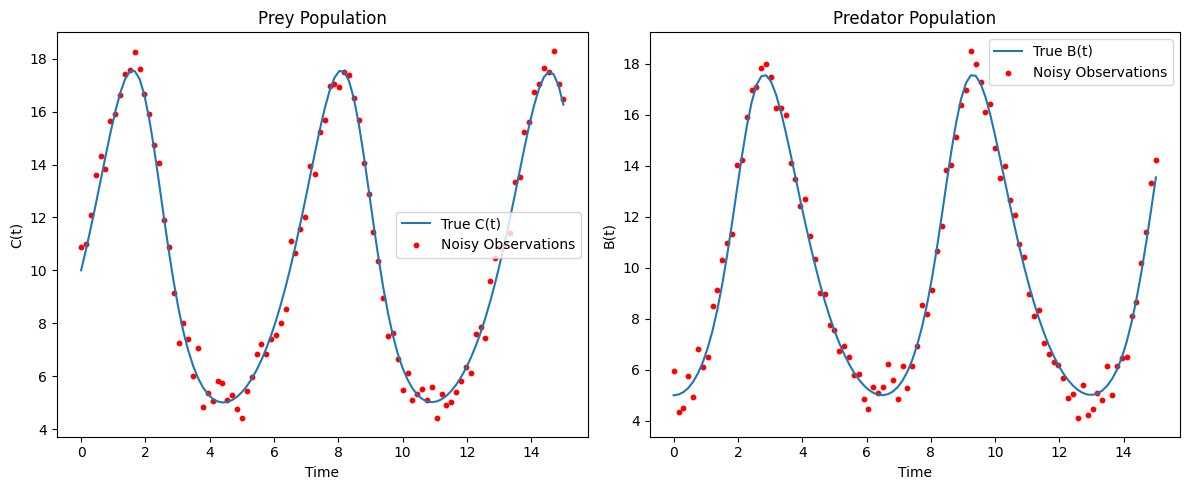

In [2]:
# [2]
# Generating Synthetic Data

# Define true parameters and initial conditions
alpha_true = 1.0
beta_C_true = 0.1
beta_B_true = 0.1
delta_true = 1.0

theta_true = np.array([alpha_true, beta_C_true, beta_B_true, delta_true])

C0_true = 10
B0_true = 5
x0_true = [C0_true, B0_true]

# Define the time points where observations are made
t_span = (0, 15)
t_eval = np.linspace(t_span[0], t_span[1], 100)

# Define the Lotka-Volterra system
def lotka_volterra(t, x, alpha, beta_C, beta_B, delta):
    C, B = x
    dCdt = alpha * C - beta_C * C * B
    dBdt = beta_B * C * B - delta * B
    return [dCdt, dBdt]

# Solve the ODE system to generate true trajectories
sol = solve_ivp(lotka_volterra, t_span, x0_true, args=tuple(theta_true), t_eval=t_eval, method='RK45')

# Extract the true trajectories
C_true = sol.y[0]
B_true = sol.y[1]

# Add Gaussian noise to the observations
noise_level = 0.5  # Adjust noise level as needed
np.random.seed(0)  # For reproducibility
C_obs = C_true + np.random.normal(0, noise_level, size=C_true.shape)
B_obs = B_true + np.random.normal(0, noise_level, size=B_true.shape)

# Plot the noisy observations and true trajectories
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(t_eval, C_true, label='True C(t)')
plt.scatter(t_eval, C_obs, color='red', s=10, label='Noisy Observations')
plt.xlabel('Time')
plt.ylabel('C(t)')
plt.legend()
plt.title('Prey Population')

plt.subplot(1, 2, 2)
plt.plot(t_eval, B_true, label='True B(t)')
plt.scatter(t_eval, B_obs, color='red', s=10, label='Noisy Observations')
plt.xlabel('Time')
plt.ylabel('B(t)')
plt.legend()
plt.title('Predator Population')

plt.tight_layout()
plt.show()

<!-- MD -->
## Generating Synthetic Data

We generate synthetic data using the true parameters and initial conditions by solving the Lotka-Volterra equations numerically. We then add Gaussian noise to simulate measurement errors.

The Lotka-Volterra equations are:

$$
\begin{aligned}
\frac{dC}{dt} &= \alpha C - \beta_C C B, \\
\frac{dB}{dt} &= \beta_B C B - \delta B.
\end{aligned}
$$

We use the `solve_ivp` function from SciPy to solve these equations.

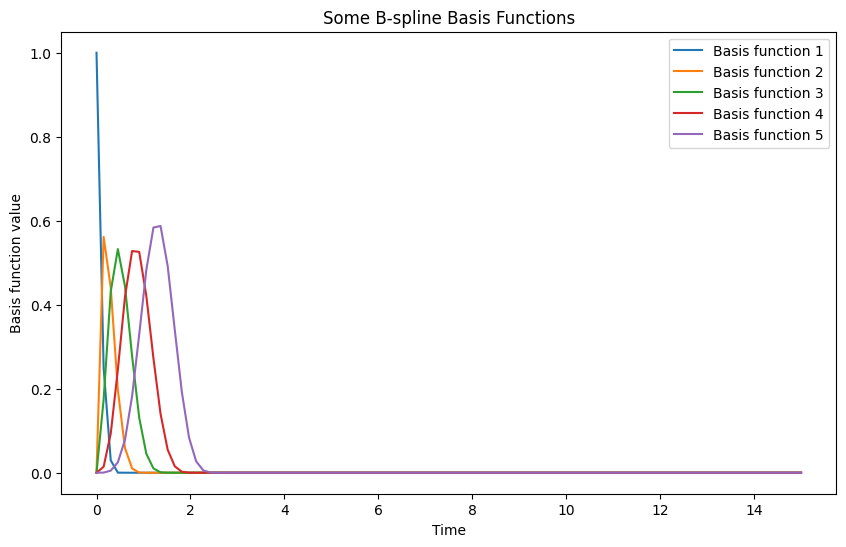

In [3]:
# [3]
# Defining Basis Functions (B-splines)

# Define B-spline basis functions
order = 5  # B-splines of degree 4
num_basis = 34  # Number of basis functions as per the reference

# Create knots between t=0 and t=15, with equal spacing
knots = np.linspace(t_span[0], t_span[1], num_basis - (order - 1))

# Add additional knots at the boundaries to satisfy B-spline requirements
knots = np.concatenate((
    np.full(order - 1, t_span[0]),
    knots,
    np.full(order - 1, t_span[1])
))

# Create list of basis functions
basis_functions = []
for i in range(len(knots) - order):
    coeffs = np.zeros(len(knots) - order)
    coeffs[i] = 1
    spline = BSpline(knots, coeffs, order - 1, extrapolate=False)
    basis_functions.append(spline)

# Evaluate basis functions at t_eval
Phi_t_eval = np.array([spline(t_eval) for spline in basis_functions])

# Plot some of the basis functions
plt.figure(figsize=(10, 6))
for i in range(min(5, len(basis_functions))):
    plt.plot(t_eval, Phi_t_eval[i], label=f'Basis function {i+1}')
plt.xlabel('Time')
plt.ylabel('Basis function value')
plt.legend()
plt.title('Some B-spline Basis Functions')
plt.show()

<!-- MD -->
## Defining Basis Functions (B-splines)

We define the basis function approximation for each variable:

$$
x(t, \mathbf{c}(\theta, \lambda)) = \sum_k c_k(\theta, \lambda) \phi_k(t)
$$

We use order 5 B-splines (degree 4 polynomials) with 34 basis functions, as per the reference:

> "We used for each variable 34 order five B-splines with knots positioned at equal steps of size one between times 15 and 45."

Since our time interval is from 0 to 15, we adjust the knots accordingly.

In [4]:
# [4]
# Defining Quadrature Points and Weights

# Define quadrature points and weights
num_quad = 151  # Must be odd for Simpson's Rule
t_quad = np.linspace(t_span[0], t_span[1], num_quad)

# Compute quadrature weights using Simpson's Rule
def simpson_weights(n, h):
    w = np.ones(n)
    w[1:-1:2] = 4
    w[2:-2:2] = 2
    w *= h / 3
    return w

h = (t_span[1] - t_span[0]) / (num_quad - 1)
w_quad = simpson_weights(num_quad, h)

# Evaluate basis functions and their derivatives at quadrature points
Phi_t_quad = np.array([spline(t_quad) for spline in basis_functions])
dPhi_t_quad = np.array([spline.derivative()(t_quad) for spline in basis_functions])

<!-- MD -->
## Defining Quadrature Points and Weights

To approximate the integral in the inner criterion $ J(\mathbf{c}, \theta, \lambda) $, we use numerical quadrature. We choose 151 equally spaced quadrature points over the time interval and use Simpson's Rule for the quadrature weights, as suggested:

> "We used 150 equally spaced quadrature points... The quadrature weights were those of Simpson's Rule."

We ensure the number of quadrature points is odd to satisfy Simpson's Rule requirements.

In [5]:
# [5]
# Symbolic Derivatives with SymPy

# Define symbolic variables
lnC_sym, lnB_sym = sp.symbols('lnC lnB', real=True)
alpha_sym, beta_C_sym, beta_B_sym, delta_sym = sp.symbols('alpha beta_C beta_B delta', real=True)
theta_sym = [alpha_sym, beta_C_sym, beta_B_sym, delta_sym]

# Define the right-hand sides of the differential equations
dlnCdt_sym = alpha_sym - beta_C_sym * sp.exp(lnB_sym)
dlnBdt_sym = beta_B_sym * sp.exp(lnC_sym) - delta_sym

# Compute derivatives of f with respect to lnC, lnB, and parameters
df1_dlnC_sym = sp.diff(dlnCdt_sym, lnC_sym)
df1_dlnB_sym = sp.diff(dlnCdt_sym, lnB_sym)
df1_dalpha_sym = sp.diff(dlnCdt_sym, alpha_sym)
df1_dbetaC_sym = sp.diff(dlnCdt_sym, beta_C_sym)

df2_dlnC_sym = sp.diff(dlnBdt_sym, lnC_sym)
df2_dlnB_sym = sp.diff(dlnBdt_sym, lnB_sym)
df2_dbetaB_sym = sp.diff(dlnBdt_sym, beta_B_sym)
df2_ddelta_sym = sp.diff(dlnBdt_sym, delta_sym)

# Convert symbolic expressions to numerical functions
vars_sym = [lnC_sym, lnB_sym, alpha_sym, beta_C_sym, beta_B_sym, delta_sym]

df1_dlnC_func = lambdify(vars_sym, df1_dlnC_sym, 'numpy')
df1_dlnB_func = lambdify(vars_sym, df1_dlnB_sym, 'numpy')
df1_dalpha_func = lambdify(vars_sym, df1_dalpha_sym, 'numpy')
df1_dbetaC_func = lambdify(vars_sym, df1_dbetaC_sym, 'numpy')

df2_dlnC_func = lambdify(vars_sym, df2_dlnC_sym, 'numpy')
df2_dlnB_func = lambdify(vars_sym, df2_dlnB_sym, 'numpy')
df2_dbetaB_func = lambdify(vars_sym, df2_dbetaB_sym, 'numpy')
df2_ddelta_func = lambdify(vars_sym, df2_ddelta_sym, 'numpy')

<!-- MD -->
## Symbolic Derivatives with SymPy

We use SymPy to compute the symbolic derivatives needed in the `CollocInfer` method, including the partial derivatives of the differential equations with respect to the state variables and parameters.

This is important for implementing the optimization steps and handling numerical issues:

> "They recommend using symbolic computation tools (like Maple or Mathematica) to derive the necessary derivatives of f for more complex systems."

In [6]:
# [6]
# Defining the Inner Criterion J(c_C, c_B, θ, λ)

# Precompute basis functions and their derivatives at observation points
dPhi_t_eval = np.array([spline.derivative()(t_eval) for spline in basis_functions])

# Define functions to compute ln x_C(t) and ln x_B(t)
def ln_x_C(c_C, Phi):
    # ln x_C(t) = sum c_C_k * phi_k(t)
    lnC = np.dot(c_C, Phi)
    return lnC

def ln_x_B(c_B, Phi):
    lnB = np.dot(c_B, Phi)
    return lnB

# Define functions to compute derivative of ln x_C(t)
def dln_x_C_dt(c_C, dPhi):
    dxdt = np.dot(c_C, dPhi)
    return dxdt

def dln_x_B_dt(c_B, dPhi):
    dxdt = np.dot(c_B, dPhi)
    return dxdt

<!-- MD -->
## Defining the Inner Criterion $ J(\mathbf{c}_C, \mathbf{c}_B, \theta, \lambda) $ 

The inner criterion combines the data fitting term and the equation fitting term. For the Lotka-Volterra model, it is defined as:

$$
\begin{aligned}
J(\mathbf{c}_C, \mathbf{c}_B, \theta, \lambda) &= \sum_j \left[ (\ln C_j - \ln x_C(t_j, \mathbf{c}_C))^2 + (\ln B_j - \ln x_B(t_j, \mathbf{c}_B))^2 \right] \\
&\quad + \lambda \int \left[ \left( \frac{d}{dt} \ln x_C(t, \mathbf{c}_C) - (\alpha - \beta_C x_B(t, \mathbf{c}_B)) \right)^2 \right. \\
&\quad \left. + \left( \frac{d}{dt} \ln x_B(t, \mathbf{c}_B) - (\beta_B x_C(t, \mathbf{c}_C) - \delta) \right)^2 \right] dt
\end{aligned}
$$

We use the precomputed basis functions and their derivatives to evaluate the approximations and their derivatives.

In [7]:
# [7]
# Compute_J function

def compute_J(c_C, c_B, theta, lambda_):
    # Data fitting term
    # Compute residuals at observation times
    lnC_obs = np.log(C_obs)
    lnB_obs = np.log(B_obs)
    lnC_model = ln_x_C(c_C, Phi_t_eval)
    lnB_model = ln_x_B(c_B, Phi_t_eval)
    res_data_C = lnC_obs - lnC_model
    res_data_B = lnB_obs - lnB_model
    data_term = np.sum(res_data_C**2) + np.sum(res_data_B**2)
    
    # Equation fitting term
    # At quadrature points
    lnC_quad = ln_x_C(c_C, Phi_t_quad)
    lnB_quad = ln_x_B(c_B, Phi_t_quad)
    dlnCdt_quad = dln_x_C_dt(c_C, dPhi_t_quad)
    dlnBdt_quad = dln_x_B_dt(c_B, dPhi_t_quad)
    
    # Compute f_C and f_B at quadrature points
    alpha, beta_C, beta_B, delta = theta
    f_C = alpha - beta_C * np.exp(lnB_quad)
    f_B = beta_B * np.exp(lnC_quad) - delta
    
    res_eq_C = dlnCdt_quad - f_C
    res_eq_B = dlnBdt_quad - f_B
    eq_term = np.sum(w_quad * (res_eq_C**2 + res_eq_B**2))
    
    # Total criterion
    J = data_term + lambda_ * eq_term
    return J

<!-- MD -->
## Computing the Inner Criterion $ J(\mathbf{c}_C, \mathbf{c}_B, \theta, \lambda) $

We implement the function `compute_J` to calculate the value of the inner criterion. It consists of two parts:

- **Data Fitting Term:** Measures the discrepancy between the observed data and the model predictions at the observation times.
- **Equation Fitting Term:** Measures how well the derivatives of the model approximations satisfy the differential equations over the time interval.

The weights $w$ from Simpson's Rule are used in the equation fitting term.

In [8]:
# [8]
# Inner Optimization: Minimizing J with respect to c_C and c_B

def inner_optimization(theta, lambda_):
    num_c = Phi_t_eval.shape[0]
    c_init = np.zeros(2 * num_c)  # [c_C, c_B]
    
    # Define the objective function for optimization
    def objective(c):
        c_C = c[:num_c]
        c_B = c[num_c:]
        return compute_J(c_C, c_B, theta, lambda_)
    
    # Constraints to avoid edge effects (if needed)
    # For simplicity, we skip them here but they can be added
    
    res = minimize(objective, c_init, method='L-BFGS-B')
    c_opt = res.x
    c_C_opt = c_opt[:num_c]
    c_B_opt = c_opt[num_c:]
    return c_C_opt, c_B_opt

<!-- MD -->
## Inner Optimization: Minimizing $ J(\mathbf{c}_C, \mathbf{c}_B, \theta, \lambda) $ with Respect to $ \mathbf{c}_C $ and $ \mathbf{c}_B $

We use a numerical optimization method to minimize $ J(\mathbf{c}_C, \mathbf{c}_B, \theta, \lambda) $ with respect to the coefficients  $ \mathbf{c}_C $ and $ \mathbf{c}_B $ for fixed $ \theta $ and $ \lambda $:

> For the inner optimization (finding $ \mathbf{c}^*(\theta, \lambda) $), they used a Gauss-Newton method.

In our implementation, we use the `L-BFGS-B` method from SciPy, which handles bound constraints and is suitable for large-scale problems.

In [9]:
# [9]
# Outer Optimization: Updating Parameters θ

def colloc_infer(theta_init, lambda_seq):
    theta = theta_init.copy()
    theta_list = []
    c_C_list = []
    c_B_list = []
    J_list = []
    
    for lambda_ in lambda_seq:
        print(f"Lambda: {lambda_}")
        # Inner optimization: optimize c for fixed θ and λ
        c_C_opt, c_B_opt = inner_optimization(theta, lambda_)
        
        # Outer optimization: optimize θ for fixed c and λ
        def outer_objective(theta):
            return compute_J(c_C_opt, c_B_opt, theta, lambda_)
        
        res = minimize(outer_objective, theta, method='L-BFGS-B')
        theta = res.x
        
        # Store results
        theta_list.append(theta)
        c_C_list.append(c_C_opt)
        c_B_list.append(c_B_opt)
        J_list.append(res.fun)
        
        # Visualize current fit
        plot_current_fit(theta, c_C_opt, c_B_opt, lambda_)
        
    return theta_list, c_C_list, c_B_list, J_list

# Function to plot current fit
def plot_current_fit(theta, c_C, c_B, lambda_):
    lnC_model = ln_x_C(c_C, Phi_t_eval)
    lnB_model = ln_x_B(c_B, Phi_t_eval)
    C_model = np.exp(lnC_model)
    B_model = np.exp(lnB_model)
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(t_eval, C_model, label='Estimated C(t)')
    plt.scatter(t_eval, C_obs, color='red', s=10, label='Noisy Observations')
    plt.xlabel('Time')
    plt.ylabel('C(t)')
    plt.legend()
    plt.title(f'Prey Population (Lambda={lambda_})')
    
    plt.subplot(1, 2, 2)
    plt.plot(t_eval, B_model, label='Estimated B(t)')
    plt.scatter(t_eval, B_obs, color='red', s=10, label='Noisy Observations')
    plt.xlabel('Time')
    plt.ylabel('B(t)')
    plt.legend()
    plt.title(f'Predator Population (Lambda={lambda_})')
    
    plt.tight_layout()
    plt.show()

<!-- MD -->
## Outer Optimization: Updating Parameters $ \theta $

We iteratively update the parameters $ \theta $  by minimizing the outer criterion $ H(\theta, \lambda) = J(\mathbf{c}^*(\theta, \lambda), \theta, \lambda) $ for each $ \lambda $:

> For the outer optimization (finding optimal $ \theta $), they also used Gauss-Newton.

In our implementation, we again use the `L-BFGS-B` method for optimization.

### Lambda Progression Strategy

We progress $ \lambda $ over a sequence of increasing values:

> "We defined $ \lambda $ by setting the sequence $ \log_{10} \lambda $ to the 11 values from -2 to 3 with step size 0.5."

This allows us to explore the trade-off between data fit and equation fit, and to examine the stability of parameter estimates.

Lambda: 0.01


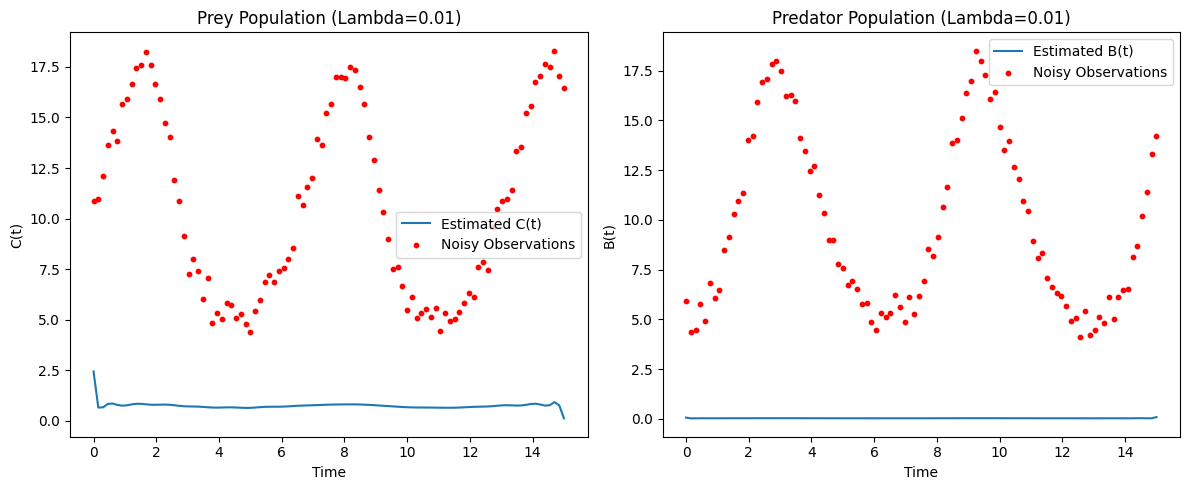

Lambda: 0.014873521072935119


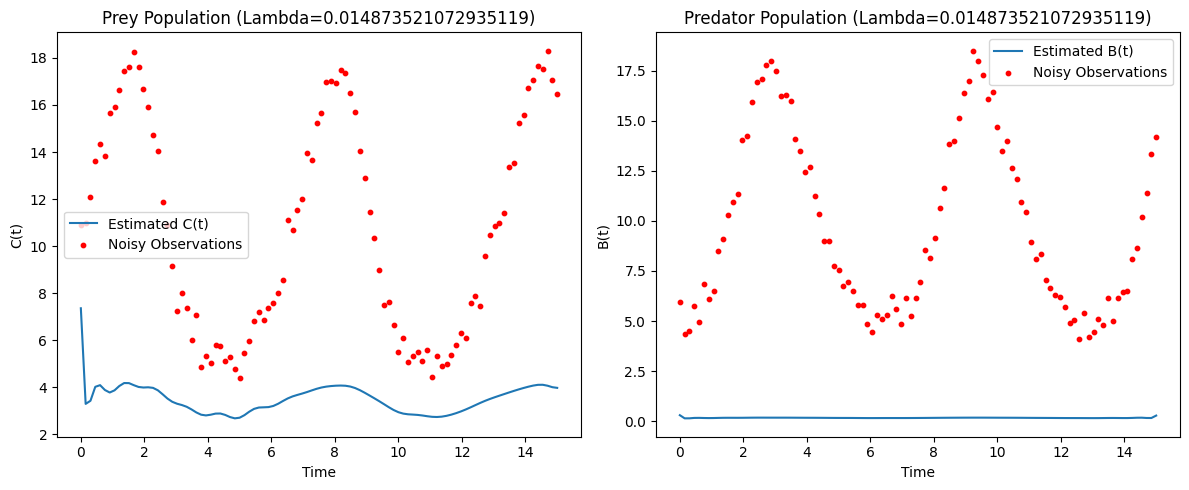

Lambda: 0.022122162910704492


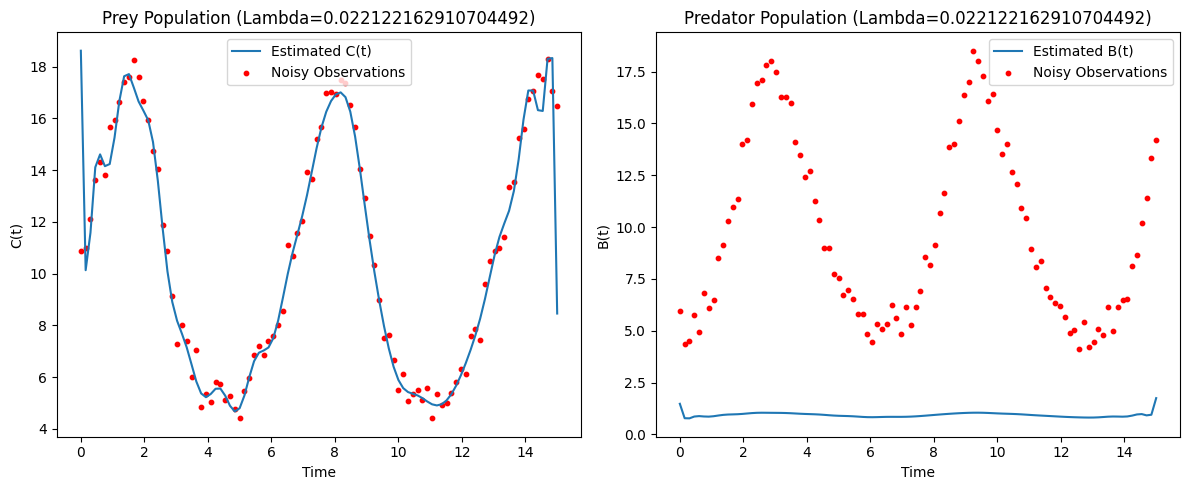

Lambda: 0.03290344562312668


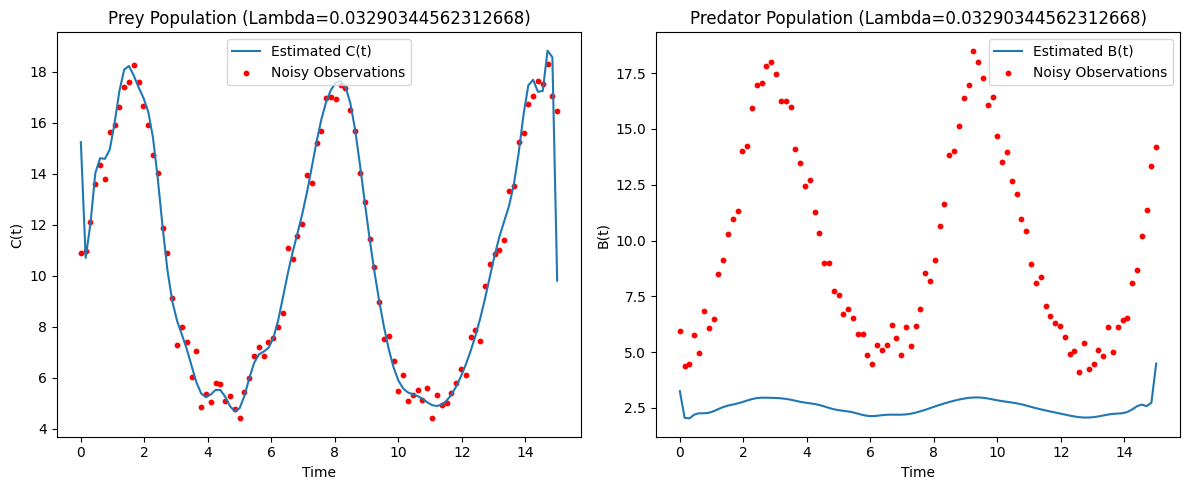

Lambda: 0.04893900918477494


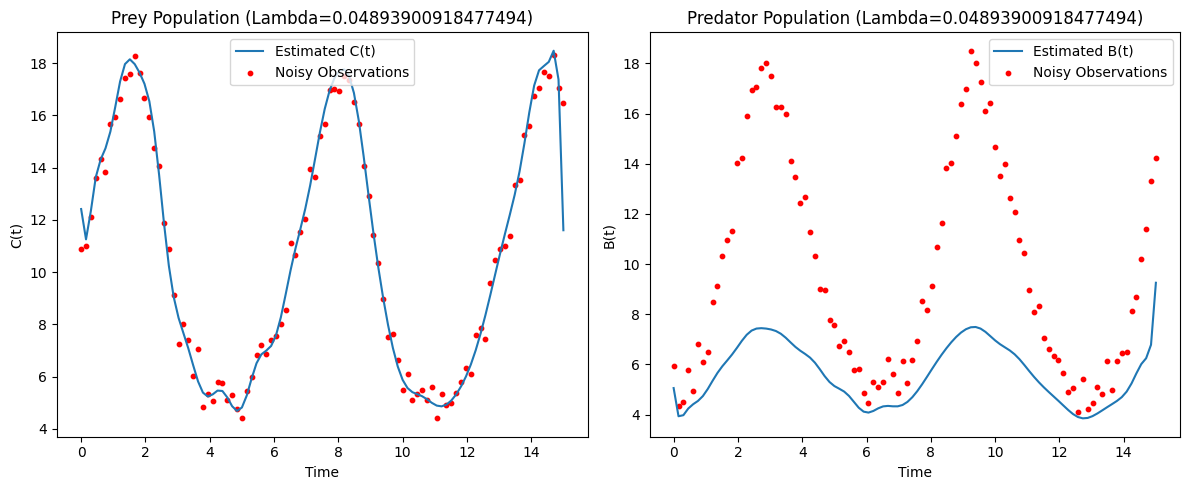

Lambda: 0.07278953843983153


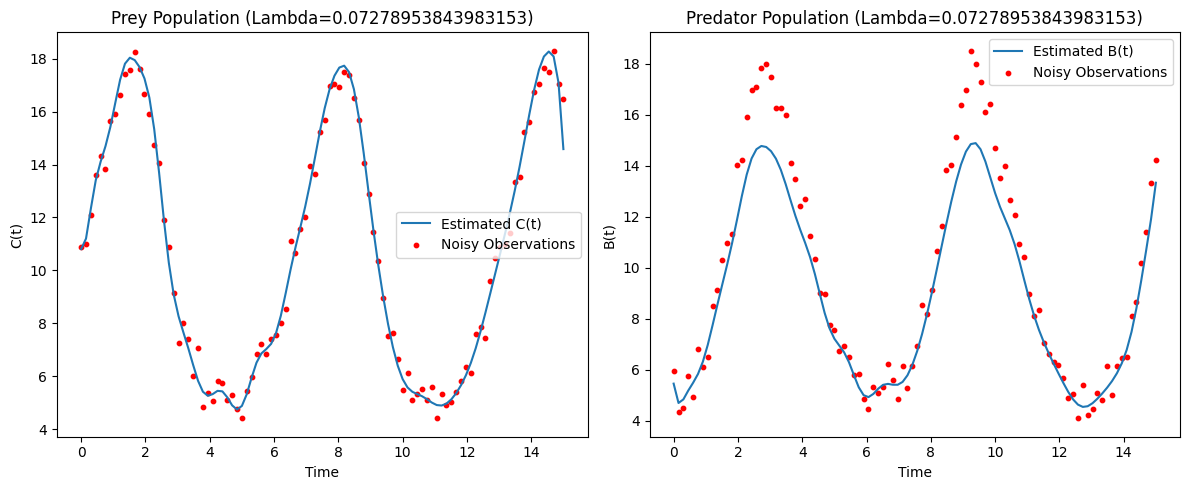

Lambda: 0.10826367338740546


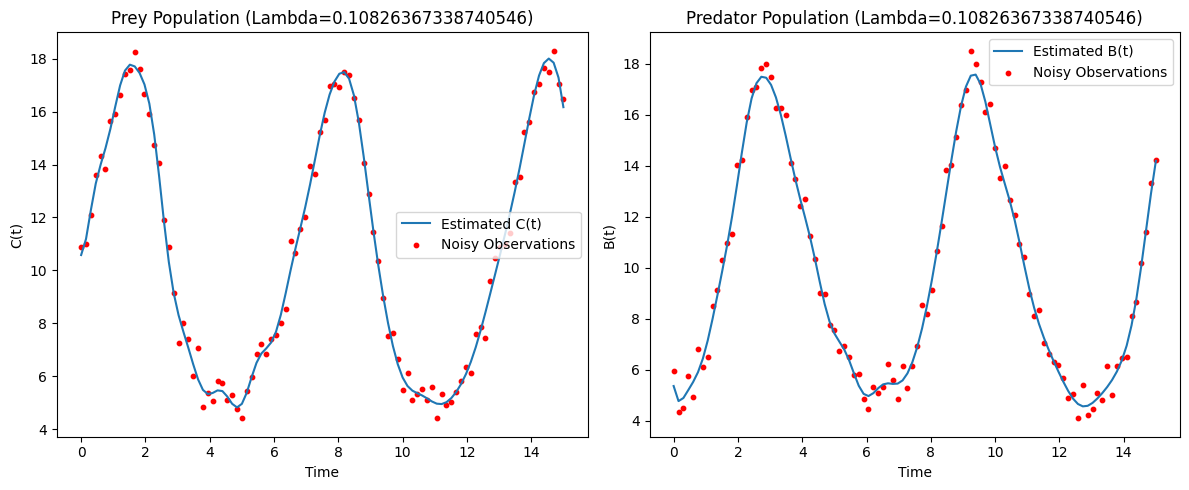

Lambda: 0.16102620275609392


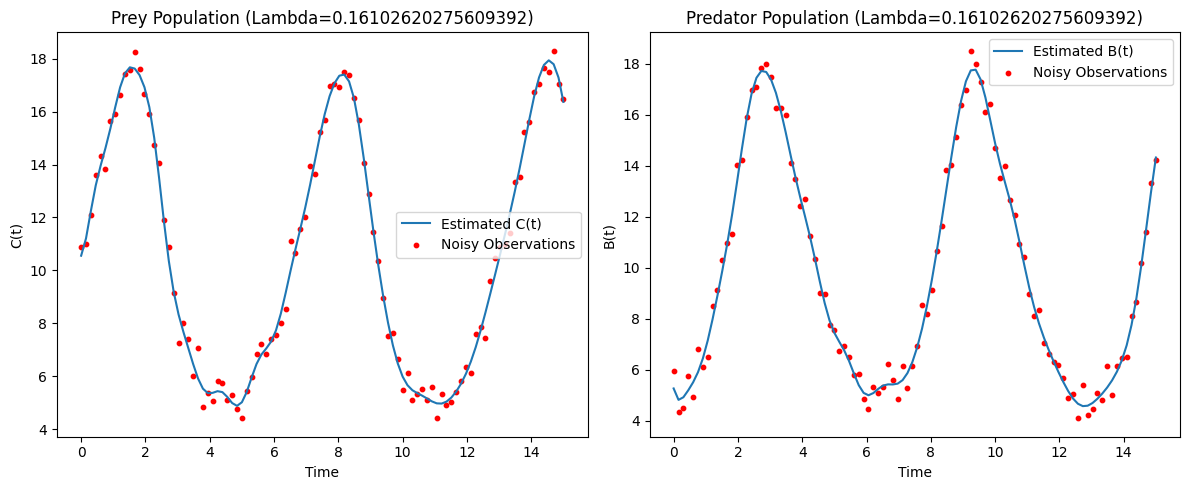

Lambda: 0.2395026619987486


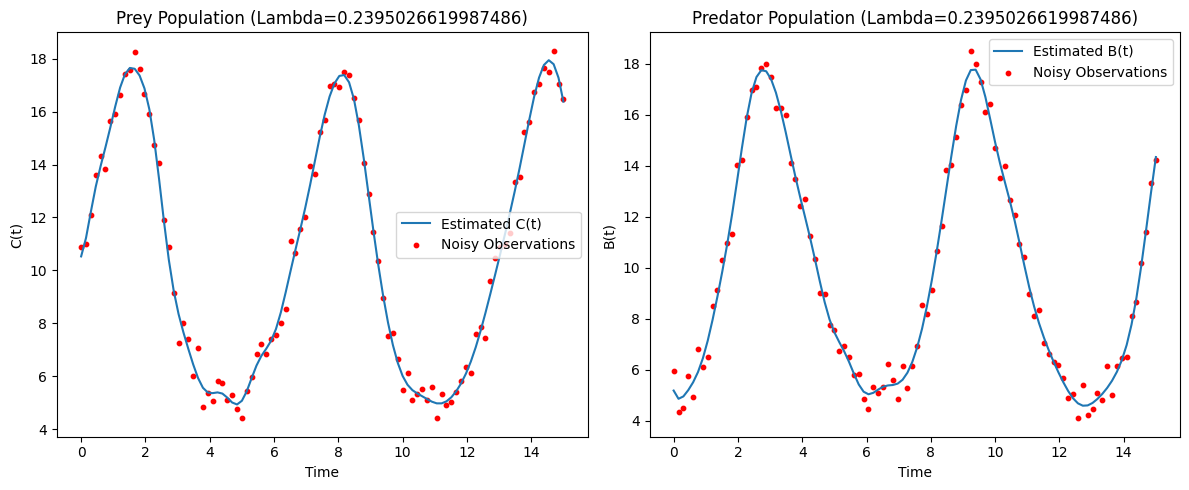

Lambda: 0.35622478902624444


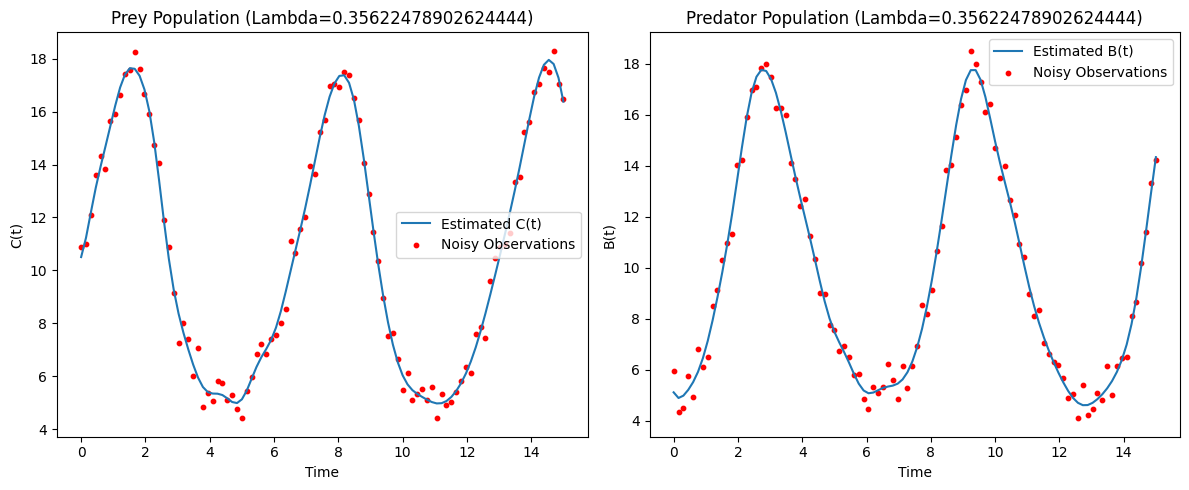

Lambda: 0.529831690628371


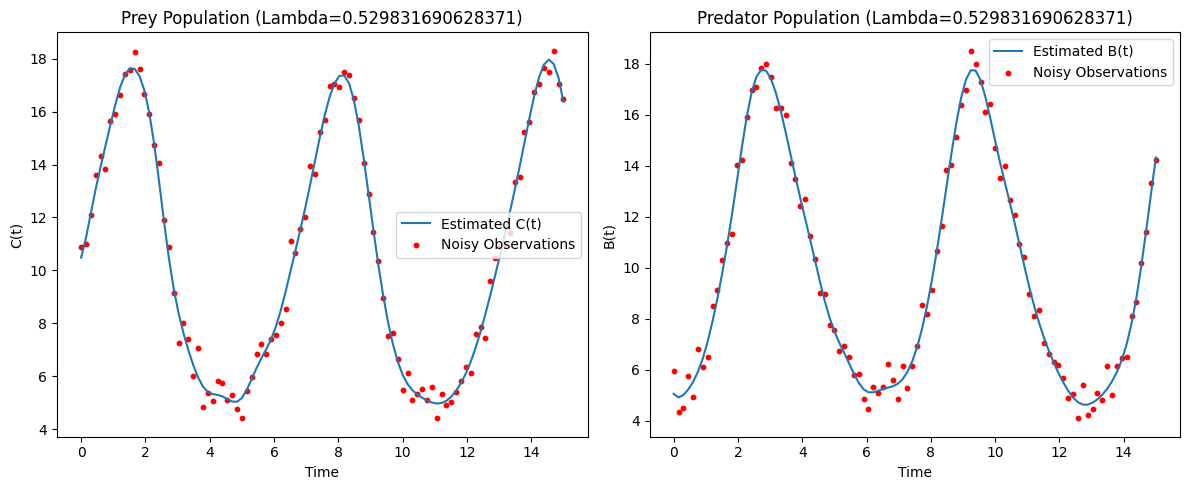

Lambda: 0.7880462815669912


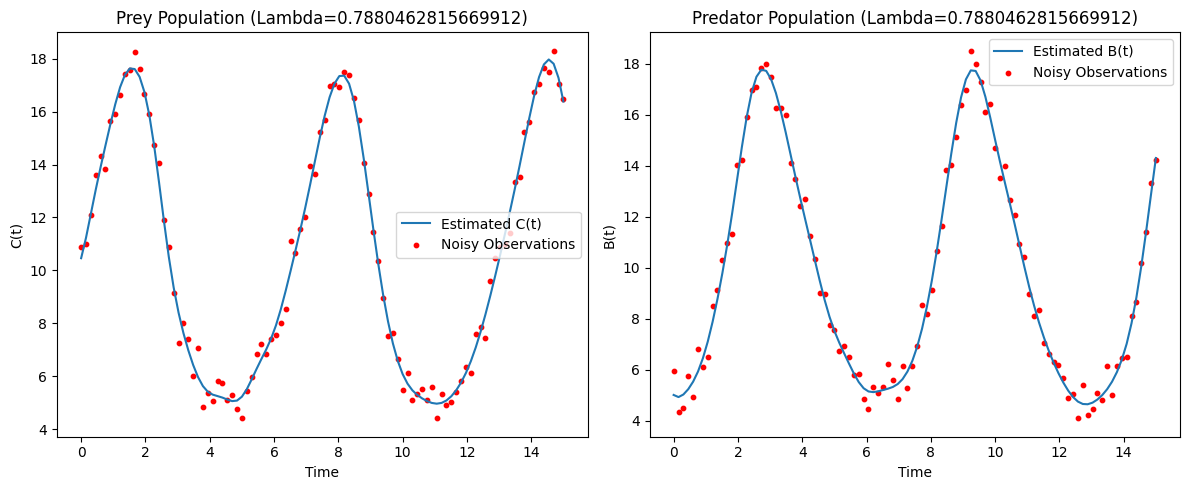

Lambda: 1.1721022975334805


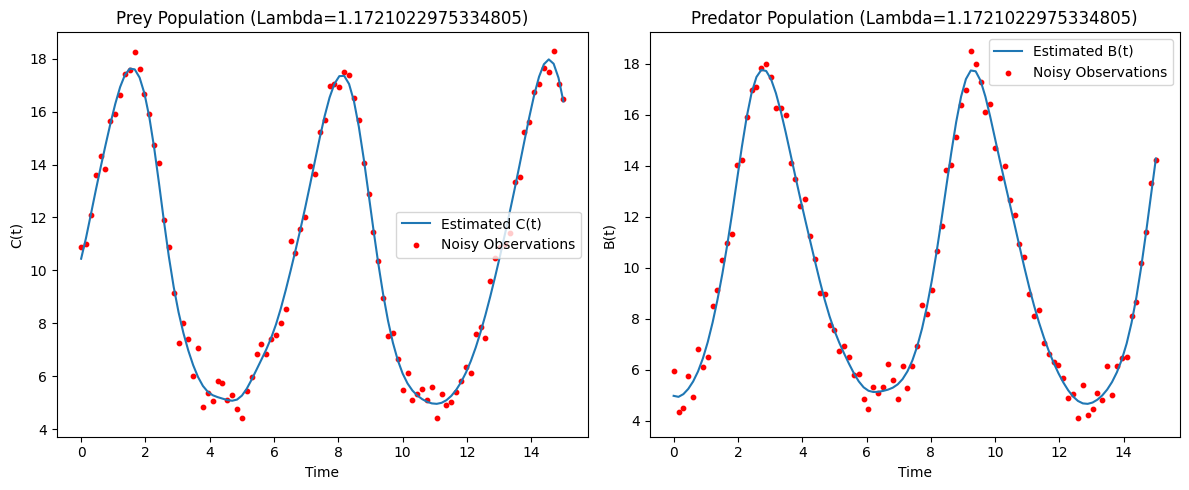

Lambda: 1.743328822199989


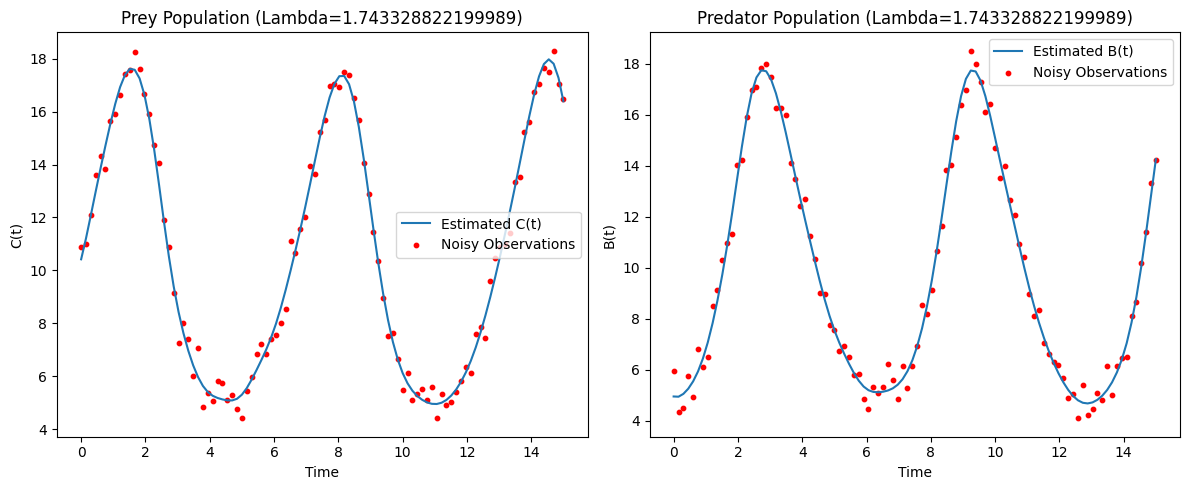

Lambda: 2.592943797404667


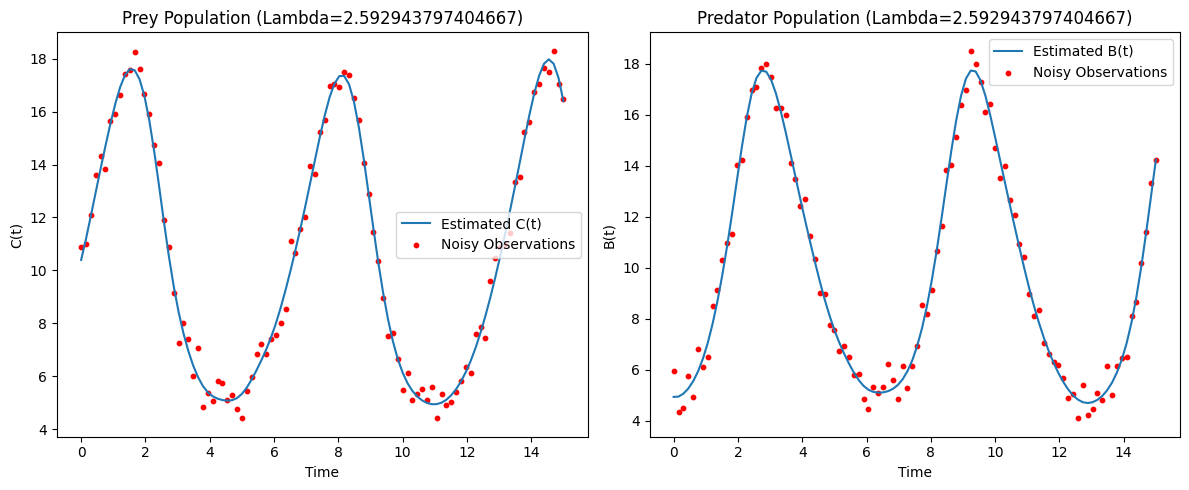

Lambda: 3.856620421163472


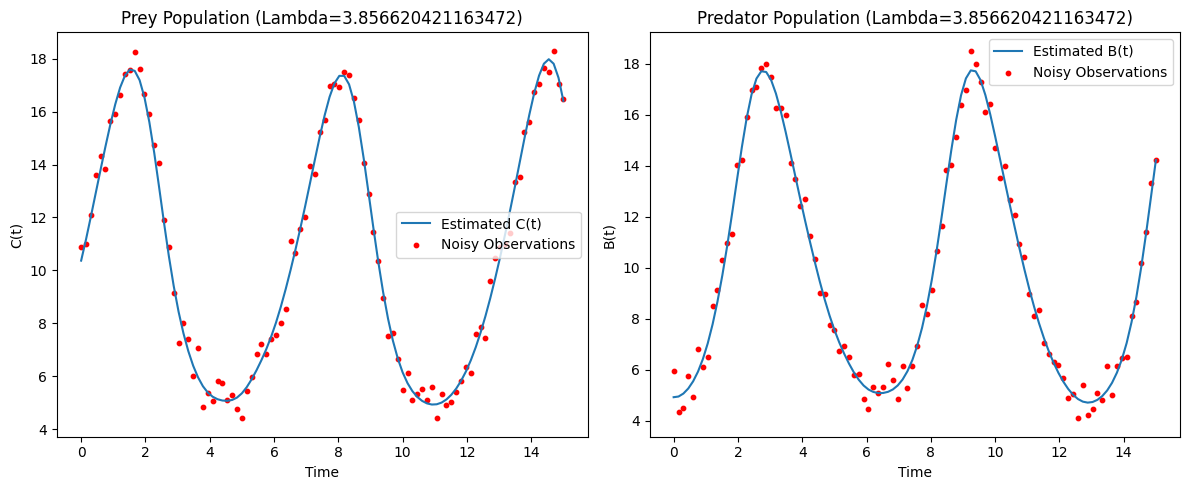

Lambda: 5.736152510448681


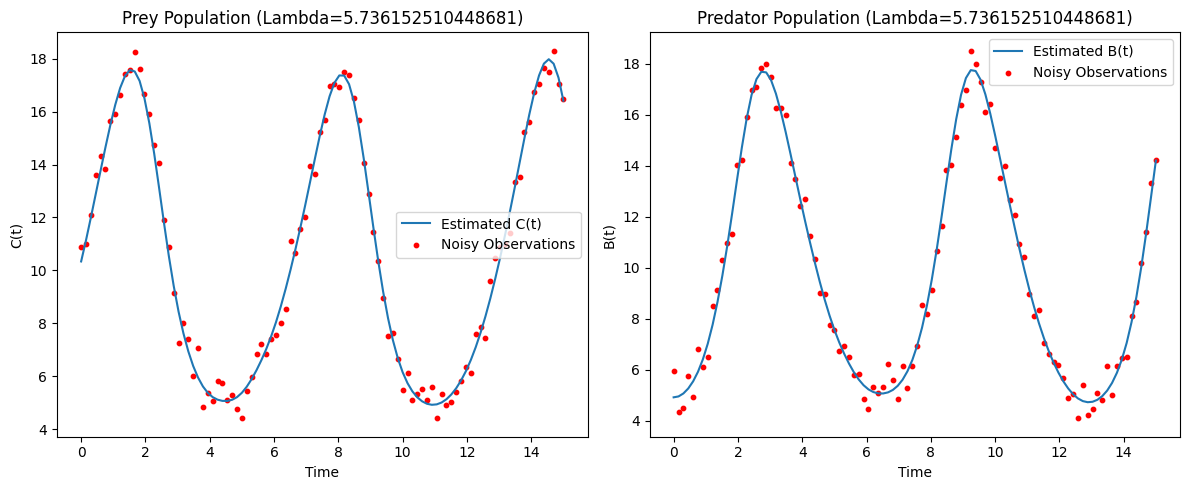

Lambda: 8.531678524172815


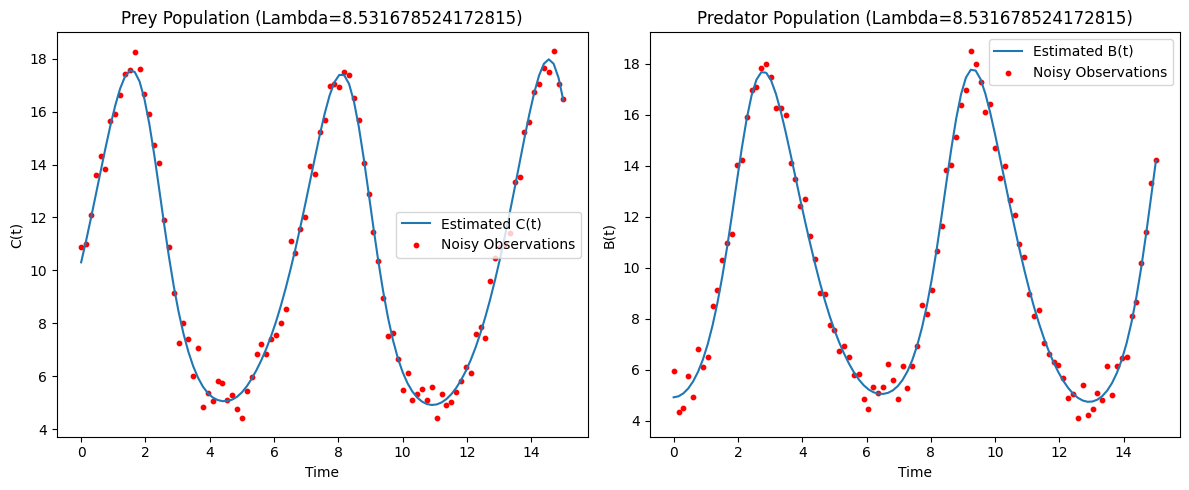

Lambda: 12.689610031679234


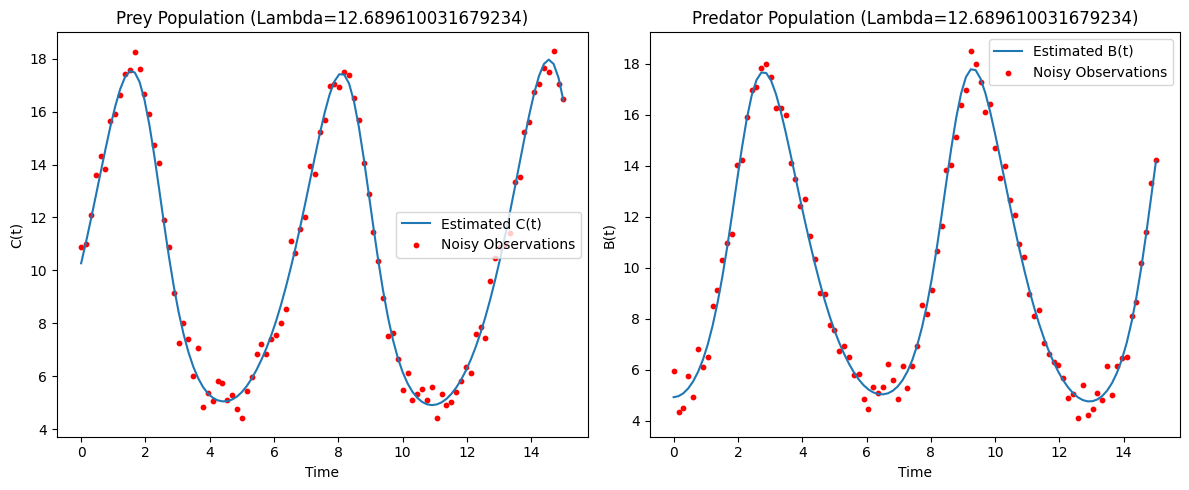

Lambda: 18.873918221350976


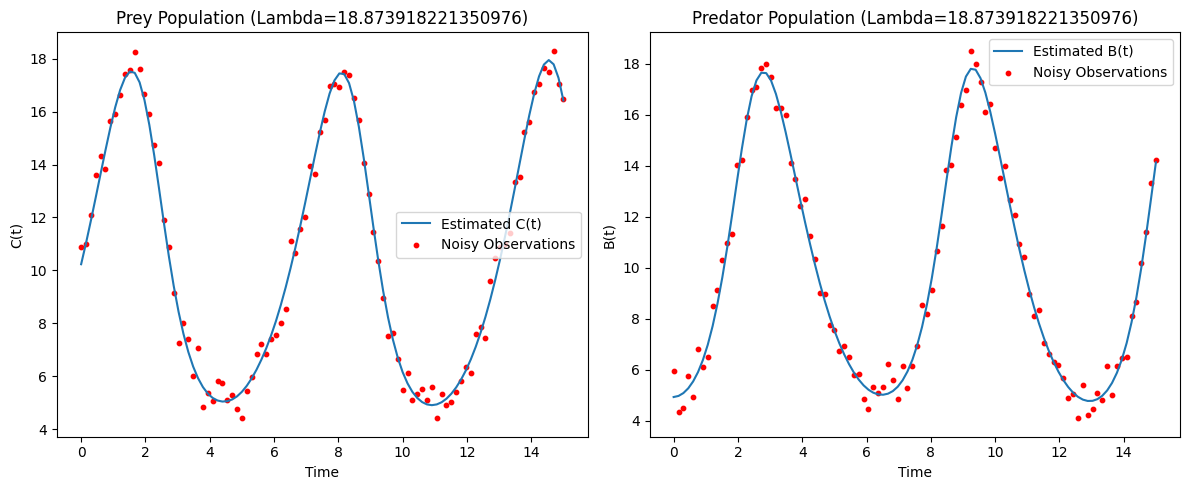

Lambda: 28.072162039411786


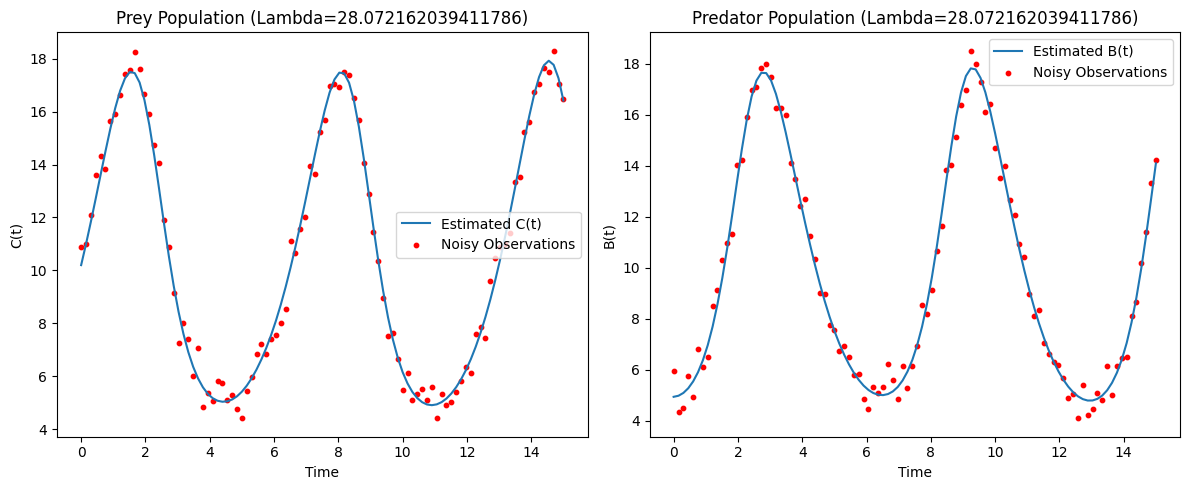

Lambda: 41.753189365604044


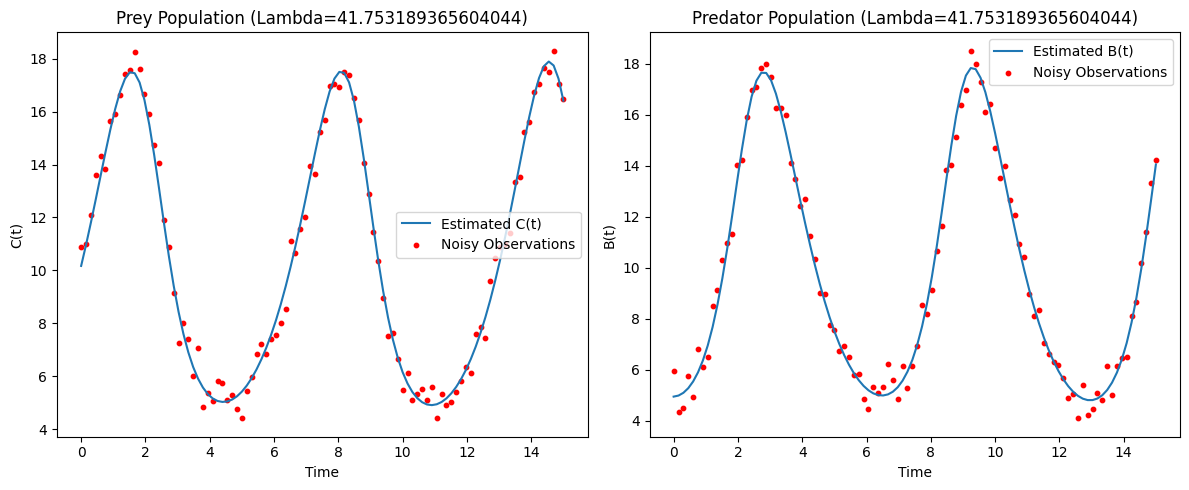

Lambda: 62.10169418915616


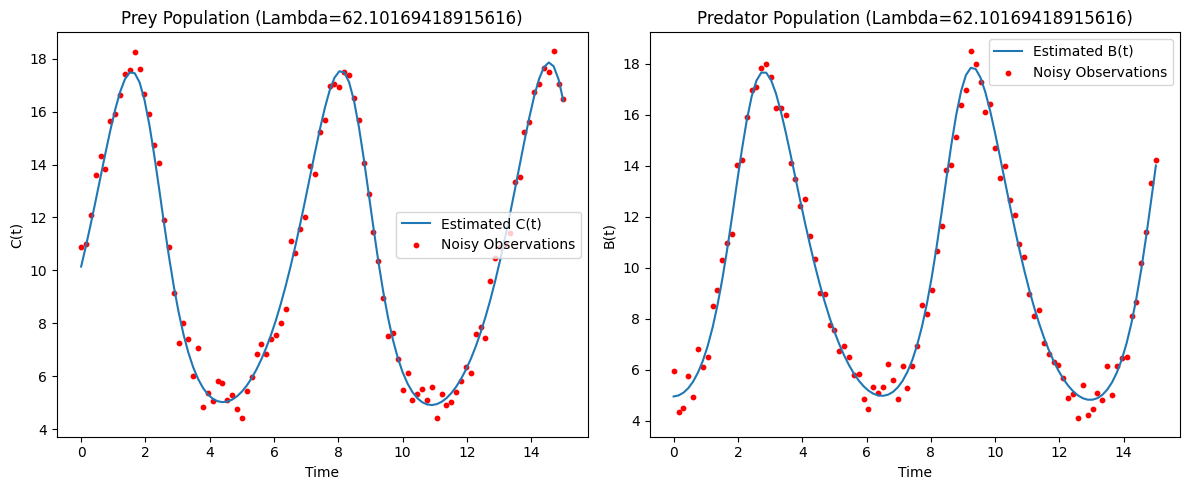

Lambda: 92.36708571873865


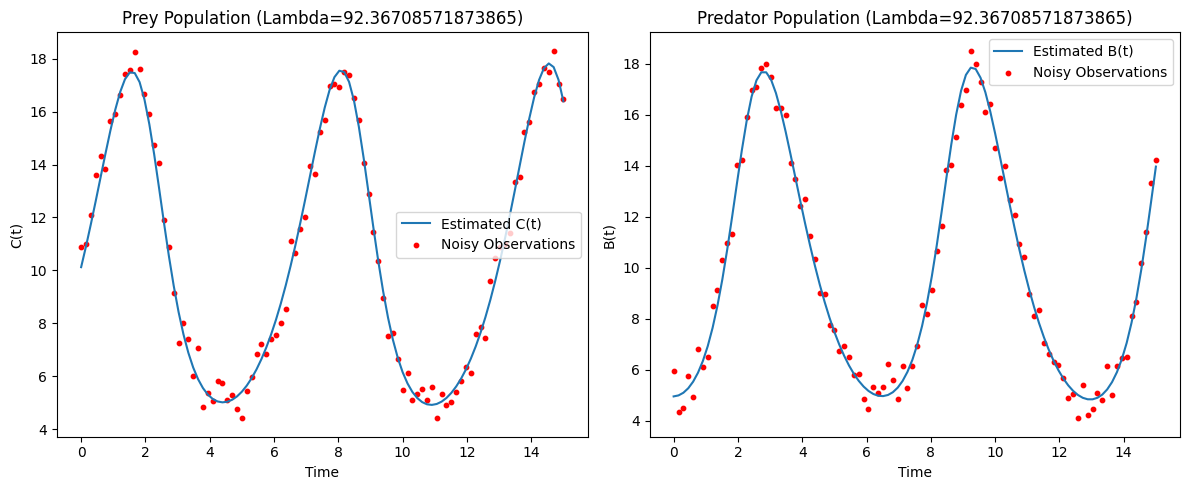

Lambda: 137.3823795883264


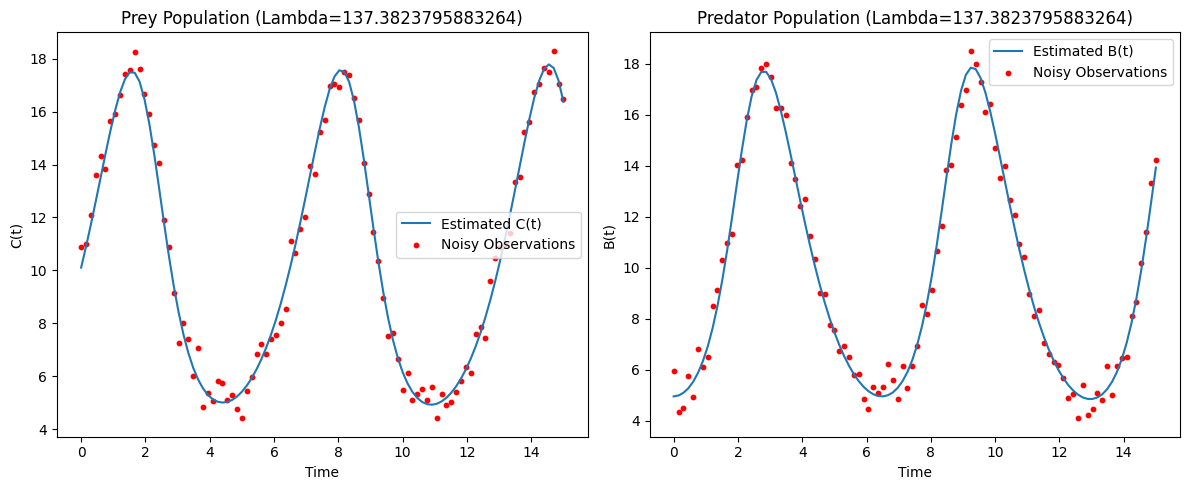

Lambda: 204.33597178569437


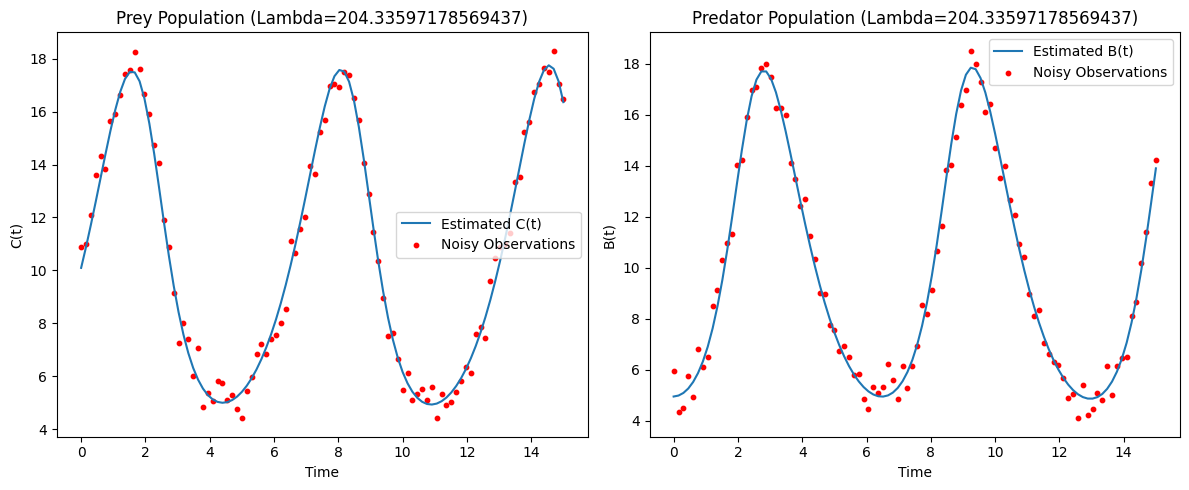

Lambda: 303.91953823132013


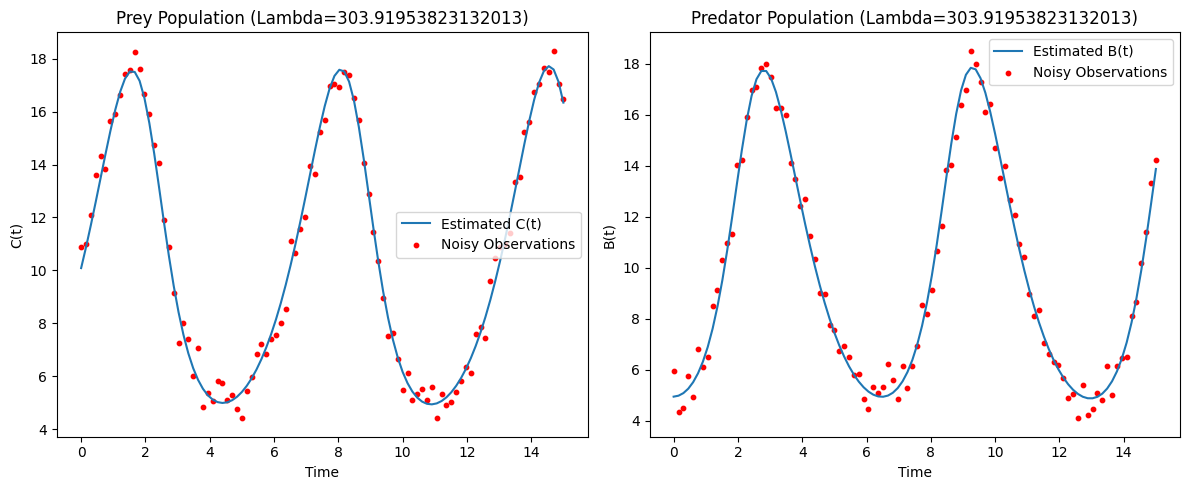

Lambda: 452.035365636025


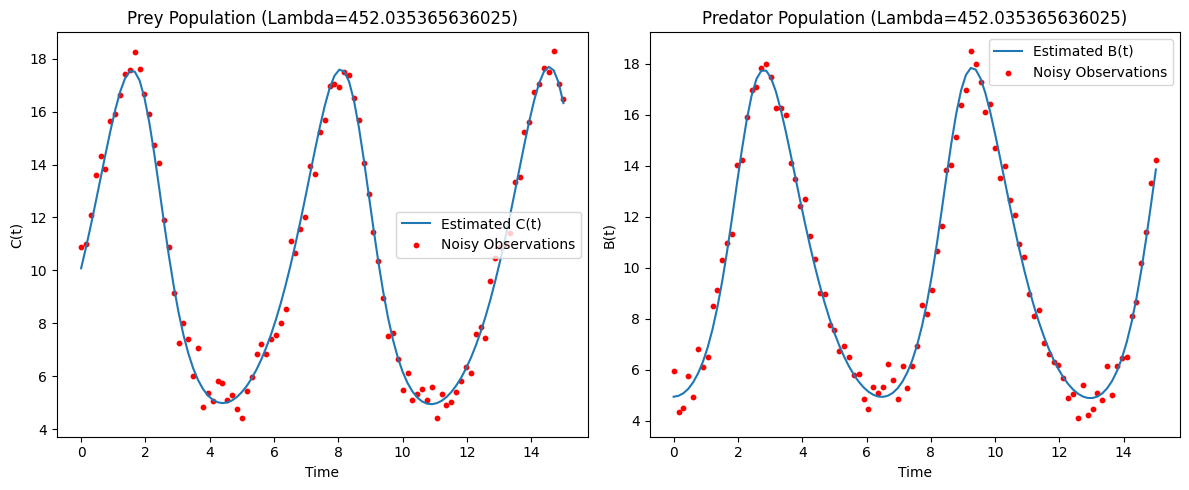

Lambda: 672.3357536499335


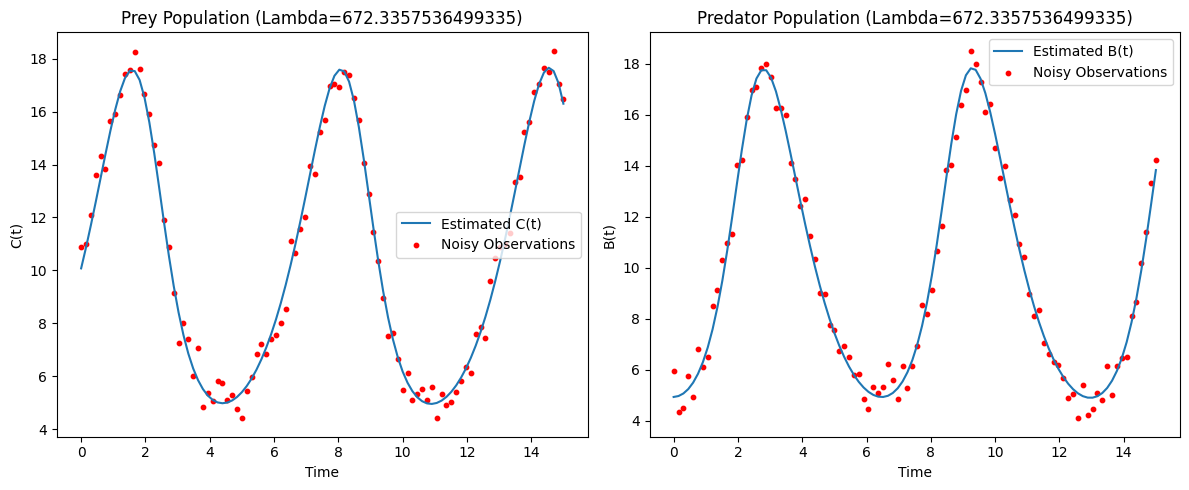

Lambda: 1000.0


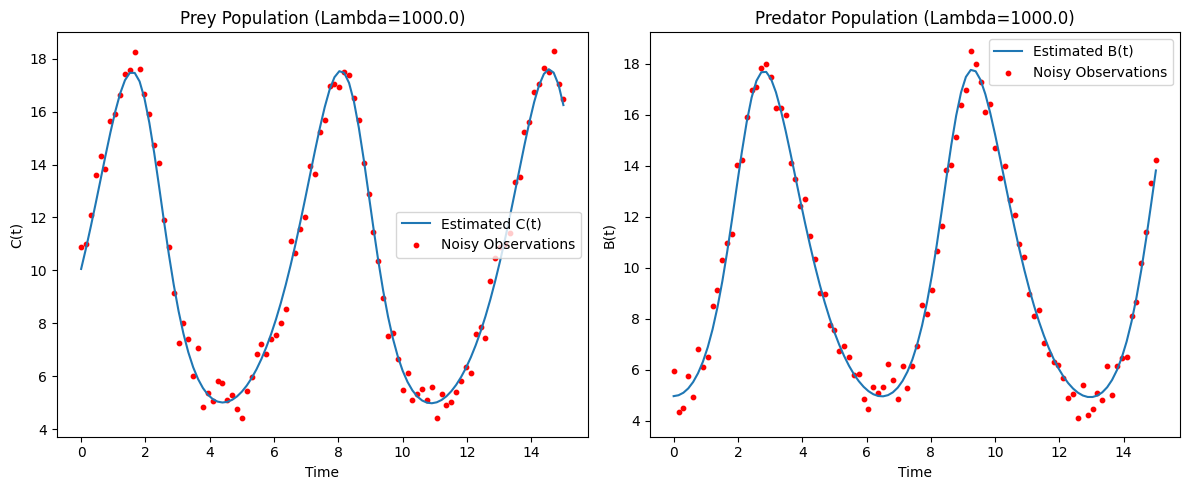

In [10]:
# [10]
# Running the CollocInfer Method

# Define initial θ and λ sequence

theta_init = np.array([-500, 300, 50, -10])  # Initial guesses for parameters

lambda_seq = np.logspace(-2, 3, 30)

# Run CollocInfer method
theta_list, c_C_list, c_B_list, J_list = colloc_infer(theta_init, lambda_seq)

<!-- MD -->
## Running the CollocInfer Method

We define a sequence of $ \lambda $ values and initial guesses for $ \theta $. We then run the `CollocInfer` method to estimate $ \theta $ and the coefficients $ \mathbf{c}_C $ and $ \mathbf{c}_B $.

> "We defined $ \lambda $ by setting the sequence $ \log_{10} \lambda $ to the 11 values from -2 to 3 with step size 0.5."

We use the estimates from the previous $ \lambda $ as the initial guess for the next $ \lambda $, as per the lambda progression strategy.

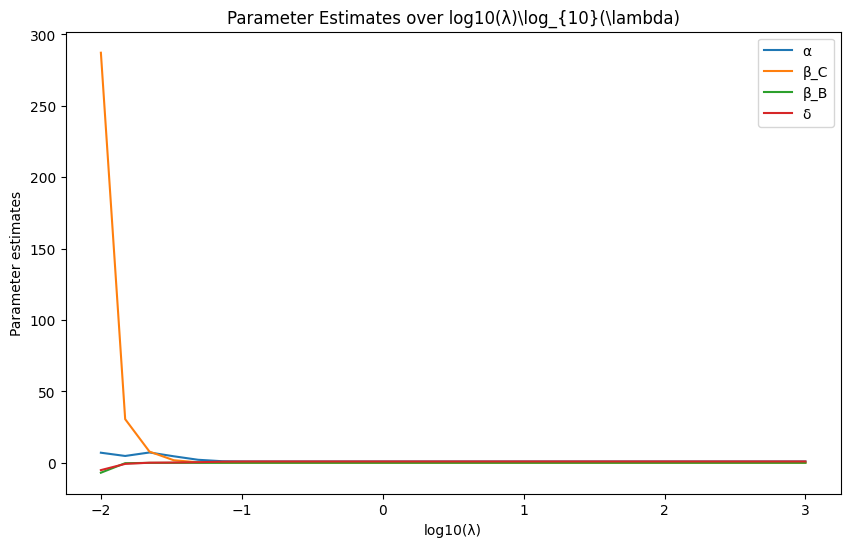

In [11]:
# [11]
# Visualizing Parameter Estimates Over λ

# Plot parameter estimates over lambda

log_lambda = np.log10(lambda_seq)
theta_array = np.array(theta_list)

plt.figure(figsize=(10, 6))
plt.plot(log_lambda, theta_array[:, 0], label="α")
plt.plot(log_lambda, theta_array[:, 1], label='β_C')
plt.plot(log_lambda, theta_array[:, 2], label='β_B')
plt.plot(log_lambda, theta_array[:, 3], label='δ')
plt.xlabel('log10(λ)')
plt.ylabel('Parameter estimates')
plt.legend()
plt.title('Parameter Estimates over log10(λ)\log_{10}(\lambda)')
plt.show()

<!-- MD -->

## Visualizing Parameter Estimates Over $ \lambda $

We plot the estimated parameters $ \theta $ as a function of $ \log_{10}(\lambda) $ to observe how they stabilize as $ \lambda $ increases.

This helps in selecting the final model based on the stability of parameter estimates:

> "They suggest comparing models with different $ \lambda $ values using criteria like GCV (Generalized Cross-Validation) or by examining the stability of parameter estimates."

## Conclusion

We have implemented the CollocInfer method for the Lotka-Volterra system, estimating both the parameters and the initial conditions from noisy data. The method iteratively updates the spline coefficients and parameters, balancing data fitting and equation fitting through the smoothing parameter $ \lambda $.

**Key Points:**

- **Basis Functions:** We used B-splines of order 5 with 34 basis functions for each variable.
- **Quadrature:** Simpson's Rule was used with 151 equally spaced quadrature points to approximate the integral in the inner criterion.
- **Optimization:** Both inner and outer optimizations were performed using the `L-BFGS-B` method.
- **Lambda Progression:** A logarithmic sequence of $ \lambda $ values was used to explore the trade-off between data fit and equation fit.

**Additional Considerations:**

- **Parameter Constraints:** We could estimate the logarithms of parameters to ensure positivity, as suggested:

  > "We switched to estimating the logarithms of the parameters after rescaling them."

- **Handling Numerical Issues:** In cases where the Hessian has negative eigenvalues, a scoring-type Hessian matrix could be used:

  > "They mentioned using a 'scoring-type Hessian matrix produced by dropping the second partial derivative term' when encountering issues with negative eigenvalues in the Hessian."

- **Initial Conditions:** Initial guesses for $ \theta $ and $ \mathbf{c} $ were based on the log-transformed data.

**Future Improvements:**

- **Edge Effects:** Avoiding edge effects by modifying the weighting in the inner criterion.
- **Confidence Intervals:** Computing confidence intervals for parameters using the Hessian of at the optimum.
- **Forcing Functions:** Incorporating known forcing functions $ u(t) $ if applicable.

$ \textrm{ The MIT License. Copyright (c) 2024: Dan Skatov.} $